# Project 5: Vehicle Detection
### By Steven Eisinger

## Tracking Pipeline
    1) Collect color and gradient features
    2) Train a Linear SVM classifier with features
    3) Sliding window search to identify possible vehicles
    4) Remove duplicates and false positives

## Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import glob
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import pickle
from moviepy.editor import VideoFileClip
%matplotlib inline

## Hyperparameters

In [2]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

## Feature Extraction (HOG, Spatial, Color)

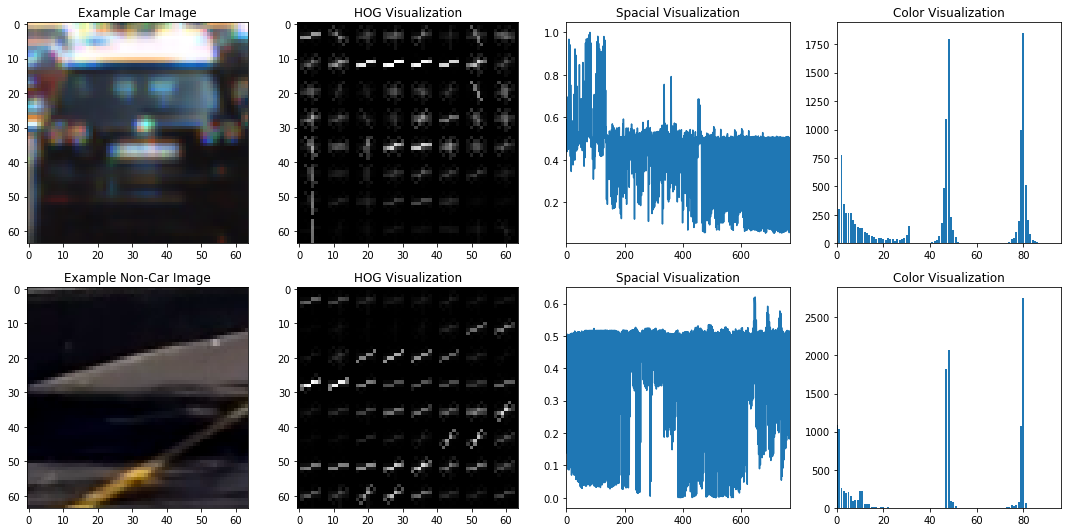

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


def cvt_color(image, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        return feature_image
    else:
        return image

# Import images
cars = glob.glob('vehicles/vehicles/*/*.png', recursive=True)
notcars = glob.glob('non-vehicles/non-vehicles/*/*.png', recursive=True)

# Generate a random index to look at a car image
car_ind = np.random.randint(0, len(cars))
notcar_ind= np.random.randint(0, len(notcars))

# Read in the image
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])
car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
notcar_gray = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)

# Call individual feature functions
car_features, car_hog_image = get_hog_features(car_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
notcar_features, notcar_hog_image = get_hog_features(notcar_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
car_image_cvt = cvt_color(car_image, color_space=color_space)
notcar_image_cvt = cvt_color(notcar_image, color_space=color_space)
car_spatial = bin_spatial(car_image_cvt, size=spatial_size)
notcar_spatial = bin_spatial(notcar_image_cvt, size=spatial_size)
car_hist = color_hist(car_image_cvt, nbins=hist_bins, bins_range=(0, 1))
notcar_hist = color_hist(notcar_image_cvt, nbins=hist_bins, bins_range=(0, 1))

# Plot the examples
fig = plt.figure(figsize=(15,7.5))
plt.subplot(241)
plt.imshow(car_image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(242)
plt.imshow(car_hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(243)
plt.plot(car_spatial)
plt.xlim(0, len(car_spatial))
plt.title('Spacial Visualization')
plt.subplot(244)
plt.bar(range(len(car_hist)), car_hist)
plt.xlim(0, len(car_hist))
plt.title('Color Visualization')
plt.subplot(245)
plt.imshow(notcar_image, cmap='gray')
plt.title('Example Non-Car Image')
plt.subplot(246)
plt.imshow(notcar_hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(247)
plt.plot(notcar_spatial)
plt.xlim(0, len(notcar_spatial))
plt.title('Spacial Visualization')
plt.subplot(248)
plt.bar(range(len(notcar_hist)), notcar_hist)
plt.xlim(0, len(notcar_hist))
plt.title('Color Visualization')
plt.tight_layout()

## Training a Classifier

In [5]:
t=time.time()
car_features = extract_features(cars, color_space=color_space, orient=orient, spatial_size=spatial_size,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hist_bins=hist_bins,
                        hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, orient=orient, spatial_size=spatial_size,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hist_bins=hist_bins,
                        hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
print('Scaling X %s...' % str(X.shape))
X_scaler = StandardScaler(copy = False).fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
print('Scaled X of shape %s' % str(scaled_X.shape))

print('Defining labels...')
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print('Splitting data into training and testing sets...')
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

106.01 Seconds to extract HOG features...
Scaling X (17760, 6156)...
Scaled X of shape (17760, 6156)
Defining labels...
Splitting data into training and testing sets...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
21.98 Seconds to train SVC...
Test Accuracy of SVC =  0.9893
My SVC predicts:  [ 0.  1.  0.  0.  0.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  1.  1.  1.  1.  0.]
0.0043 Seconds to predict 10 labels with SVC


#### Save the Classifier (Create Checkpoint)

In [6]:
pickle.dump(svc, open('classifier.pkl','wb'))
pickle.dump(X_scaler, open('scaler.pkl','wb'))

#### Load the Classifier (Load Checkpoint)

In [6]:
svc = pickle.load(open('classifier.pkl','rb'))
X_scaler = pickle.load(open('scaler.pkl','rb'))

## Sliding Window Search

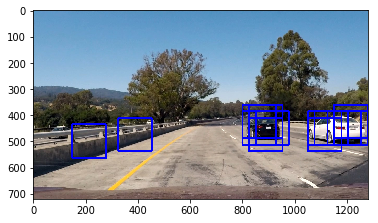

In [9]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

# window_size_range = range(64, 196, 32)
window_size_range = [128]
y_start_stops = [[360, 720]]
windows = []
for window_size, y_start_stop in zip(window_size_range, y_start_stops):
    windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(window_size, window_size), xy_overlap=(0.8, 0.8)))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6) 

plt.imshow(window_img)

## Removing Duplicates and False Positives

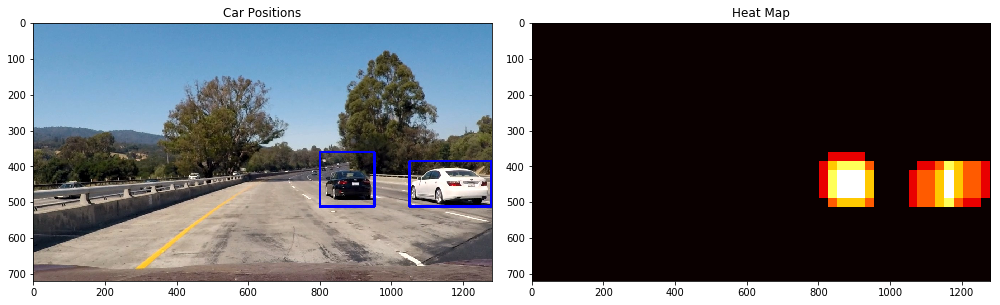

In [10]:
# Read in image similar to one shown above 
image = mpimg.imread('test_images/test1.jpg')
image = image.astype(np.float32)/255
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,1), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(14,14))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Vehicle Detection Pipeline

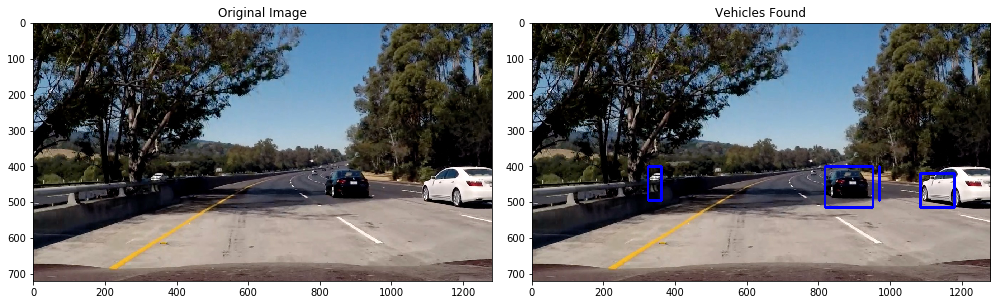

In [11]:
def find_vehicles(img, clf, scaler, y_start_stop, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9,
                  pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    # Convert image type if it is of type 8-bit int
    image = np.copy(img)
    if img.dtype == np.uint8:
        image = image.astype(np.float32)/255
        
    # Find window sizes
    windows = []
    window_sizes = [48, 96, 200]
    y_start_stops = [[400, 450], [400, 530], [400, 720]]
    x_start_stops = [[330, 950], [0, 1280], [0, 1280]]
    for window_size, y_start_stop, x_start_stop in zip(window_sizes, y_start_stops, x_start_stops):
        windows.extend(slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                            xy_window=(window_size, window_size), xy_overlap=(0.8, 0.8)))
        
    # Select windows which classifier identifies
    hot_windows = search_windows(image, windows, clf, scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
    # Add heat to each window box
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

image = mpimg.imread('test_images/test5.jpg')
vehicles_found = find_vehicles(image, svc, X_scaler, y_start_stop, color_space=color_space, spatial_size=spatial_size,
                               hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat,
                               hist_feat=hist_feat, hog_feat=hog_feat)

fig = plt.figure(figsize=(14,14))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(vehicles_found)
plt.title('Vehicles Found')
fig.tight_layout()

## Video Processing

In [12]:
def process_image(img):
    out_img = find_vehicles(img, svc, X_scaler, y_start_stop, color_space=color_space, spatial_size=spatial_size,
                         hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                         cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat,
                         hist_feat=hist_feat, hog_feat=hog_feat)
    out_img *= 255
    return out_img.astype(np.uint8)
movie_output = 'find_vehicles.mp4'
clip = VideoFileClip("project_video.mp4")
lane_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(movie_output, audio=False)

[MoviePy] >>>> Building video find_vehicles.mp4
[MoviePy] Writing video find_vehicles.mp4


100%|█████████▉| 1260/1261 [39:08<00:01,  1.87s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: find_vehicles.mp4 

CPU times: user 39min 6s, sys: 1.86 s, total: 39min 8s
Wall time: 39min 9s


## Video Output

In [29]:
from moviepy.editor import ipython_display
ipython_display(movie_output, width=640)

 ## Testing Cell

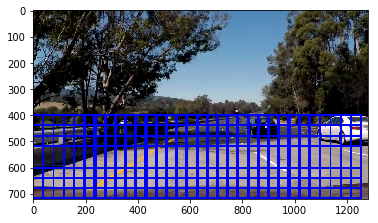

In [26]:
# Find window sizes
window_image = mpimg.imread('test_images/test5.jpg')
windows = []
window_sizes = [48, 96, 200]
y_start_stops = [[400, 450], [400, 530], [400, 720]]
x_start_stops = [[330, 950], [0, 1280], [0, 1280]]
for window_size, y_start_stop, x_start_stop in zip(window_sizes, y_start_stops, x_start_stops):
    windows.append(slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(window_size, window_size), xy_overlap=(0.8, 0.8)))
    
window_img = draw_boxes(window_image, windows[2], color=(0, 0, 255), thick=6)
    

plt.imshow(window_img)